In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable 
import torchvision
from torchvision import transforms
from torch import utils
from sklearn.preprocessing import StandardScaler
import random
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_score, recall_score
from tqdm import tqdm, notebook 
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")
torch.backends.cudnn.benchmark = True
use_cuda

False

In [3]:
class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, input_dim, n_hiden, first_hiden = None, center_hiden = None , last_hiden = 2): 
        if first_hiden == None:
            first_hiden = input_dim
        if center_hiden == None:
            center_hiden = first_hiden
        super(LogisticRegressionModel, self).__init__()
        self.leyer_list = nn.ModuleList()
        layer_w = input_dim
        hiden_dim = first_hiden
        for i in range(n_hiden+1):
            self.leyer_list.append(nn.Linear(layer_w, hiden_dim))
            if i < (n_hiden/2)-1:
                layer_w = hiden_dim
                hiden_dim = (int)((i+1)*(2*(center_hiden-first_hiden)/n_hiden)+first_hiden)
            else:
                layer_w = hiden_dim
                hiden_dim = (int)((i-n_hiden/2+1)*(2*(last_hiden-center_hiden)/n_hiden)+center_hiden)
        self.leyer_list.append(nn.Linear(layer_w, 1))
    def forward(self, x): 
        Relu = nn.LeakyReLU()
        Sigm = nn.Sigmoid()
        for layer in self.leyer_list[:-1]:
            x = Relu(layer(x))
        y = Sigm(self.leyer_list[-1](x))
        return y

In [4]:
from torch.utils import data

class Dataset(data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, features, labels):
        'Initialization'
        self.labels = labels
        self.features = features

    def __len__(self):
        'Denotes the total number of samples'
        return len(self.features)

    def __getitem__(self, index):
        'Generates one sample of data'
        x = self.features[index]
        y = self.labels[index]
        return x, y


In [5]:
def acc(features, targets):
    targets = targets.to(device).view(-1,1).detach()
    outputs = model(features.to(device)).detach()
    loss_eval = loss_fun(outputs, targets)
    pred = (outputs>0.5).float()
    precision = precision_score(pred, targets)
    recal = recall_score(pred, targets)
    pred = (pred.to(device) == targets).sum()
    return pred.float()/len(outputs), loss_eval.detach(), precision, recal

In [6]:
def plot_training_classification(run_hist):
    """Plot the training history of the classification model."""
    fig, ax = plt.subplots(1,3, figsize=(20,6), sharex=True)
    x = np.arange(len(run_hist["train_loss"]))
    ax[0].plot(x, run_hist["train_loss"],'b', marker='.', label="train loss")
    ax[0].plot(x, run_hist["test_loss"],'r', marker='.', label="test loss")
    ax[0].legend()
    ax[1].plot(x, run_hist["train_acc"],'b', marker='.', label="train accuracy")
    ax[1].plot(x, run_hist["test_acc"],'r', marker='.', label="test accuracy")
    ax[1].legend()
    ax[2].plot(x, run_hist["train_precision"],'b', marker='.', label="train precision")
    ax[2].plot(x, run_hist["test_precision"],'r', marker='.', label="test precision")
    ax[2].legend()

In [7]:
def plot_roc(x, y, model):
    output = model(x.to(device))
    fpr, tpr, thresholds = roc_curve(y.cpu().detach().numpy(), output.cpu().detach().numpy())
    plt.figure()
    lw = 2
    auc_val = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
           lw=lw, label='ROC curve (area = %0.2f)' % auc_val)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()
    return auc_val

In [17]:
train_data_file = "~/data2.csv"
data = pd.read_csv(train_data_file)
features = data.drop(["Unnamed: 0", "eventID", "track_particle_key", "track_position_z", "track_ghostProbability", "track_chi2", "track_phi", "track_position_phi"] , axis=1).astype(np.float64)
isDown = data.particle_isDown.values.astype(np.float64)
noVelo = data.particle_isDown_noVelo.values.astype(np.float64)
features = features.drop(["particle_isDown_noVelo", "particle_isDown", features.columns[0]], axis=1).values
targets = torch.FloatTensor([isDown, noVelo])
print(targets)

tensor([[1., 1., 0.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [9]:
scaler = StandardScaler()
scaler.fit(features)
X = scaler.transform(features)
X_train, X_test, y_train, y_test = train_test_split(X, targets, test_size = 0.2)

In [10]:
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test).to(device)
y_test = torch.FloatTensor(y_test).to(device)
X_train.shape

torch.Size([125988, 10])

In [11]:
epochs = 201
batch_size = 100
input_dim = X_train.shape[1]
output_dim = 1
lr_rate = 0.005
n_hiden = 7
first_hiden = 18
center_hiden = 13
last_hiden = 5
params = [n_hiden, first_hiden, center_hiden, last_hiden]


In [12]:
model = LogisticRegressionModel(input_dim, *params)
print(model)

LogisticRegressionModel(
  (leyer_list): ModuleList(
    (0): Linear(in_features=10, out_features=18, bias=True)
    (1): Linear(in_features=18, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=15, bias=True)
    (3): Linear(in_features=15, out_features=13, bias=True)
    (4): Linear(in_features=13, out_features=11, bias=True)
    (5): Linear(in_features=11, out_features=9, bias=True)
    (6): Linear(in_features=9, out_features=7, bias=True)
    (7): Linear(in_features=7, out_features=5, bias=True)
    (8): Linear(in_features=5, out_features=1, bias=True)
  )
)


n_hiden: 7, first_hiden: 18, center_hiden: 13 last_hiden: 5


/home/halaka/pytorch-env/lib64/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples.
  'recall', 'true', average, warn_for)


epoch 1
train: loss 0.7139, acc = 0.4352, precision= 0.0000, recal= 0.0000
test:  loss 0.7142, acc = 0.4339, precision = 0.0000, recal= 0.0000
epoch 2
train: loss 0.4791, acc = 0.7845, precision= 0.8694, recal= 0.7761
test:  loss 0.4812, acc = 0.7816, precision = 0.8694, recal= 0.7731
epoch 3
train: loss 0.4448, acc = 0.8038, precision= 0.9275, recal= 0.7714
test:  loss 0.4512, acc = 0.8007, precision = 0.9264, recal= 0.7689
epoch 4
train: loss 0.4471, acc = 0.7975, precision= 0.9263, recal= 0.7648
test:  loss 0.4557, acc = 0.7924, precision = 0.9219, recal= 0.7616
epoch 5
train: loss 0.4403, acc = 0.8044, precision= 0.8895, recal= 0.7905
test:  loss 0.4472, acc = 0.7971, precision = 0.8840, recal= 0.7848
epoch 6
train: loss 0.4316, acc = 0.8074, precision= 0.8813, recal= 0.7986
test:  loss 0.4393, acc = 0.8014, precision = 0.8788, recal= 0.7928
epoch 7
train: loss 0.4390, acc = 0.8042, precision= 0.8784, recal= 0.7960
test:  loss 0.4461, acc = 0.7999, precision = 0.8781, recal= 0.7913

epoch 58
train: loss 0.3966, acc = 0.8280, precision= 0.9209, recal= 0.8033
test:  loss 0.4101, acc = 0.8230, precision = 0.9179, recal= 0.7993
epoch 59
train: loss 0.3968, acc = 0.8283, precision= 0.9243, recal= 0.8019
test:  loss 0.4106, acc = 0.8236, precision = 0.9199, recal= 0.7990
epoch 60
train: loss 0.3961, acc = 0.8275, precision= 0.9233, recal= 0.8014
test:  loss 0.4094, acc = 0.8217, precision = 0.9190, recal= 0.7971
epoch 61
train: loss 0.3961, acc = 0.8283, precision= 0.9148, recal= 0.8069
test:  loss 0.4100, acc = 0.8226, precision = 0.9104, recal= 0.8028
epoch 62
train: loss 0.3961, acc = 0.8285, precision= 0.9309, recal= 0.7988
test:  loss 0.4086, acc = 0.8224, precision = 0.9274, recal= 0.7937
epoch 63
train: loss 0.3961, acc = 0.8282, precision= 0.9198, recal= 0.8042
test:  loss 0.4098, acc = 0.8231, precision = 0.9155, recal= 0.8006
epoch 64
train: loss 0.3966, acc = 0.8283, precision= 0.9301, recal= 0.7989
test:  loss 0.4088, acc = 0.8215, precision = 0.9255, recal=

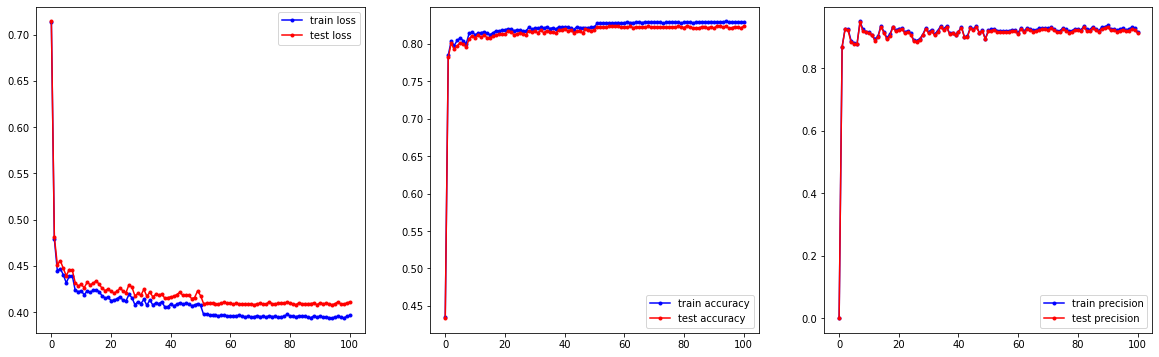

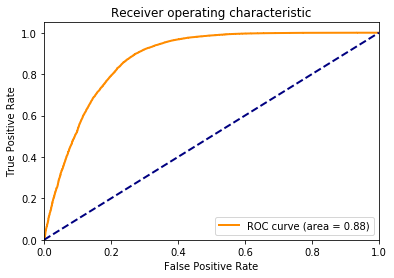

epoch 102
train: loss 0.3924, acc = 0.8301, precision= 0.9278, recal= 0.8023
test:  loss 0.4081, acc = 0.8239, precision = 0.9235, recal= 0.7974
epoch 103
train: loss 0.3922, acc = 0.8300, precision= 0.9257, recal= 0.8033
test:  loss 0.4080, acc = 0.8237, precision = 0.9217, recal= 0.7981
epoch 104
train: loss 0.3921, acc = 0.8304, precision= 0.9262, recal= 0.8035
test:  loss 0.4079, acc = 0.8246, precision = 0.9219, recal= 0.7991
epoch 105
train: loss 0.3919, acc = 0.8302, precision= 0.9265, recal= 0.8031
test:  loss 0.4080, acc = 0.8239, precision = 0.9221, recal= 0.7982
epoch 106
train: loss 0.3920, acc = 0.8305, precision= 0.9270, recal= 0.8032
test:  loss 0.4077, acc = 0.8237, precision = 0.9224, recal= 0.7978
epoch 107
train: loss 0.3921, acc = 0.8305, precision= 0.9308, recal= 0.8012
test:  loss 0.4080, acc = 0.8238, precision = 0.9256, recal= 0.7963
epoch 108
train: loss 0.3919, acc = 0.8305, precision= 0.9283, recal= 0.8025
test:  loss 0.4083, acc = 0.8243, precision = 0.9240,

epoch 159
train: loss 0.3908, acc = 0.8308, precision= 0.9292, recal= 0.8025
test:  loss 0.4087, acc = 0.8230, precision = 0.9232, recal= 0.7965
epoch 160
train: loss 0.3908, acc = 0.8310, precision= 0.9292, recal= 0.8027
test:  loss 0.4087, acc = 0.8229, precision = 0.9233, recal= 0.7964
epoch 161
train: loss 0.3908, acc = 0.8308, precision= 0.9293, recal= 0.8024
test:  loss 0.4087, acc = 0.8229, precision = 0.9233, recal= 0.7963
epoch 162
train: loss 0.3908, acc = 0.8308, precision= 0.9291, recal= 0.8025
test:  loss 0.4088, acc = 0.8226, precision = 0.9228, recal= 0.7962
epoch 163
train: loss 0.3908, acc = 0.8309, precision= 0.9293, recal= 0.8025
test:  loss 0.4087, acc = 0.8231, precision = 0.9233, recal= 0.7965
epoch 164
train: loss 0.3908, acc = 0.8309, precision= 0.9296, recal= 0.8023
test:  loss 0.4087, acc = 0.8230, precision = 0.9236, recal= 0.7963
epoch 165
train: loss 0.3908, acc = 0.8310, precision= 0.9302, recal= 0.8021
test:  loss 0.4087, acc = 0.8227, precision = 0.9242,

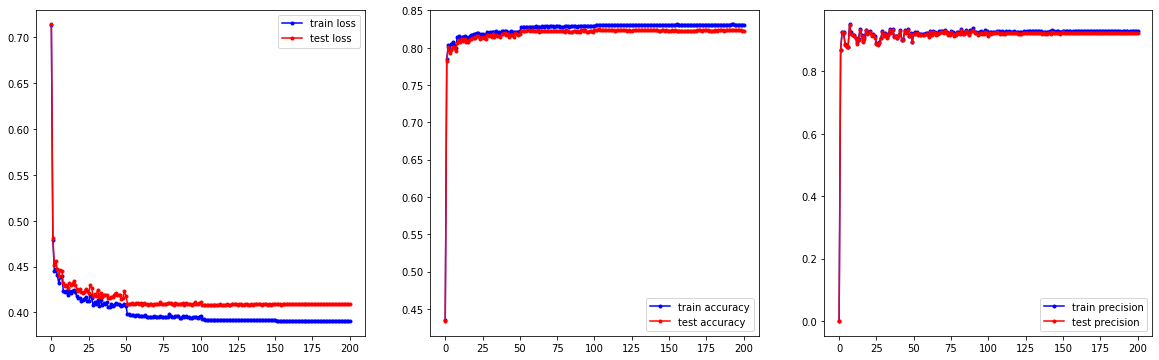

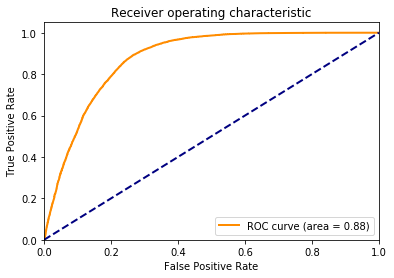

In [13]:
stat_dict = {
    "train_loss" : [],
    "test_loss" : [],
    "train_acc" : [],
    "test_acc" : [],
    "train_precision" : [],
    "test_precision" : [],
    "train_recal" : [],
    "test_recal" : []
}
print("n_hiden: {}, first_hiden: {}, center_hiden: {} last_hiden: {}".format(*params))

loss_fun = torch.nn.BCELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr_rate)

model.to(device)
n_epoch = len(stat_dict["train_acc"])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.2)
for epoch in range(n_epoch, epochs):
    training_set = Dataset(X_train, y_train)
    training_generator = utils.data.DataLoader(training_set, batch_size = batch_size, shuffle = True)
    train_acc, train_loss, train_precision, train_recal= acc(X_train, y_train)
    test_acc, test_loss, test_precision, test_recal = acc(X_test, y_test)
    for batch_features, batch_targets in training_generator:
        batch_features, batch_targets = batch_features.to(device).view(-1,input_dim), batch_targets.to(device).view(-1,1)
        def closure(batch_features, batch_targets):
            optimizer.zero_grad()
            pred = model(batch_features)
            loss_val = loss_fun(pred, batch_targets)
            loss_val.backward()
        optimizer.step(closure(batch_features, batch_targets))
        optimizer.zero_grad()
    scheduler.step()
    stat_dict["test_loss"].append(test_loss)
    stat_dict["test_acc"].append(test_acc)
    stat_dict["test_precision"].append(test_precision)
    stat_dict["test_recal"].append(test_recal)
    
    stat_dict["train_loss"].append(train_loss)    
    stat_dict["train_acc"].append(train_acc)
    stat_dict["train_precision"].append(train_precision)    
    stat_dict["train_recal"].append(train_recal)
    print("epoch {0}".format(epoch+1))
    print("train: loss {0:.4f}, acc = {1:.4f}, precision= {2:.4f}, recal= {3:.4f}".format(train_loss, train_acc, train_precision, train_recal))
    print("test:  loss {0:.4f}, acc = {1:.4f}, precision = {2:.4f}, recal= {3:.4f}".format( test_loss, test_acc, test_precision, test_recal))
    if epoch!=0 and epoch%100==0:
        plot_training_classification(stat_dict)
        auc_val = plot_roc(X_test, y_test, model)


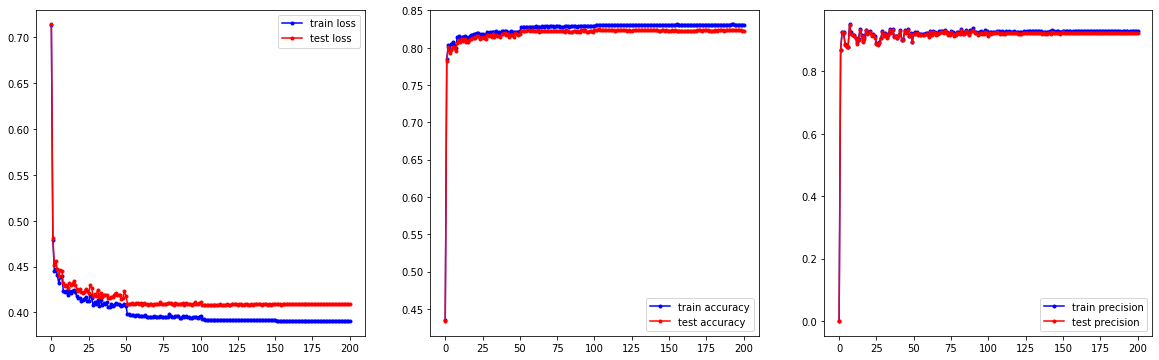

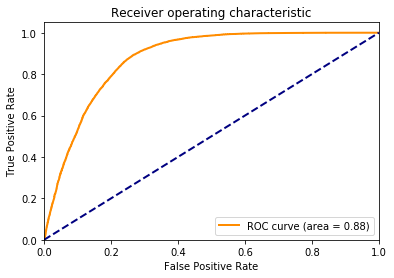

In [14]:
plot_training_classification(stat_dict)
auc_val = plot_roc(X_test, y_test, model)